In [1]:
%matplotlib inline
import random
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import itertools as it
import calcs as c
import pickle

## Subproject 1

<b>Problem 1</b>: For a 3 $\times$ 3 lattice, there are $2^9$ configurations possible.

In [2]:
configs = 2**9
print("There are " + str(configs) + " configurations.")

There are 512 configurations.


<b>Problem 2:</b> The code for this is found in the <i>calcs.py</i> file and enumerates all possible configurations.

In [3]:
# creating the lattice (code is in the calcs.py file)
lattices = c.create_lattices()

In [4]:
# Here is a sample
print(lattices[:, :, 100])

[[ 1.  1. -1.]
 [-1.  1.  1.]
 [-1.  1.  1.]]


<b>Problem 3:</b> The code for this is given by the functions "hammy" and "nn" in the <i>calcs.py</i> file.

<b>Problem 4:</b> Using the code in <b>3</b> to calculate the partition function and internal energy of the lattice at $T=0.1$ K and $T=1000$ K.

In [5]:
J, H = 1.0, 0.0
T = [0.1, 1000.0]
Q_lo_T, avg_lo = c.get_Q_and_E(0.1, 1.0, 0.0, lattices)
Q_hi_T, avg_hi = c.get_Q_and_E(1000.0, 1.0, 0.0, lattices)

In [6]:
print("The average energy in the low temperature regime is " + str(avg_lo)[0:9] + ".")
print("The average energy in the high temperature regime is " + str(avg_hi)[0:9] + ".")
print("The partition function in the low temperature regime is "
      + str(Q_lo_T)[0:9] + str(Q_lo_T)[-4:] + ".")
print("The partition function in the high temperature regime is " + str(Q_hi_T)[0:9] + ".")

The average energy in the low temperature regime is -18.0.
The average energy in the high temperature regime is -0.018018.
The partition function in the low temperature regime is 2.9787684e+78.
The partition function in the high temperature regime is 512.00461.


<b>Explanation:</b> In the low $T$ limit, I would expect $Q$ to blow up to infinity as we are summing exponentials with exponents dependent on inverse temperature. In the high $T$ limit, I would expect $Q$ to approach $512$ because $1/kT \rightarrow 0$ as $T \rightarrow \infty$, making $Q$ approximately equivalent to adding $1$ to itself $512$ times. These results are in agreement with this mathematical argument.

## Subproject 2

<b>Problem 1</b>: Energy calculation using Onsager's solution for the internal energy of infinitely sized lattices. The expression used was
\begin{align*}
    U = - J \coth(2 \beta J) \left[ 1 + \dfrac{2}{\pi} \left( 2 \tanh^2(2 \beta J) - 1 \right) \int_0^{\pi/2}  \dfrac{{\rm d}\theta}{\sqrt{1-4k(1+k)^{-2}\sin^2\theta}} \right],
\end{align*}
where
\begin{align*}
    k = {\rm csch}^2(2 \beta J).
\end{align*}

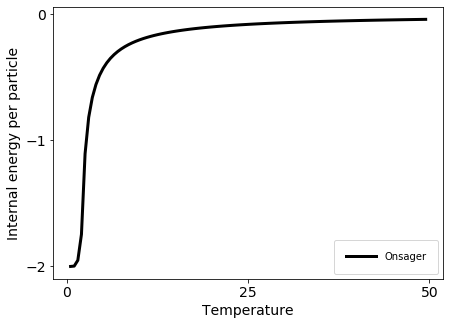

In [7]:
J = 1.0
T_ons, E_ons = c.onsager(J)
E_plt_list = [E_ons]
c.plt_onsager(T_ons, E_plt_list, "Onsager.pdf")

<b>Problem 2</b>: Calculating the enrgy per particle of the $3 \times 3$ lattice and comparing these data to Onsager's solution found in <i>Problem 1</i>.

In [8]:
E_array = np.zeros_like(T_ons, float)
print(T_ons.shape)
for k in range(T_ons.shape[-1]):
    Temp = T_ons[k]
    E_array[k] = c.get_Q_and_E(Temp, 1.0, 0.0, lattices, True)[1]

(99,)


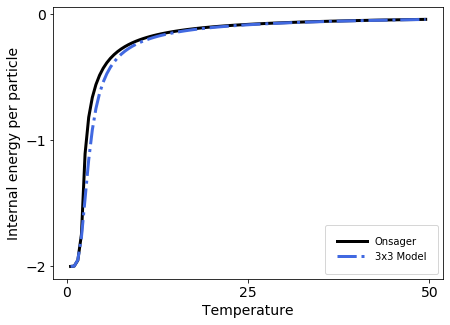

In [9]:
E_plt_list.append(E_array)
c.plt_onsager(T_ons, E_plt_list, "OnsagerVs3x3.pdf")

## Subproject 3

<b>Problem 1</b>: The <i>rnd()</i> function in <i>calcs.py</i> returns either $-1$ or $+1$ at random. The code is explained within the function docstring.

In [10]:
print(c.rnd())

1


<b>Problem 2</b>: The <i>rndN()</i> function in <i>calcs.py</i> returns two random integers $i$ and $j$ that are between 0 and $N$, where $N \times N$ is the size of the lattice.

In [11]:
print(c.rndN(10))

(6, 6)


In [12]:
# Sanity check: comparison to results from subproject 1
Ts = [0.1, 1000]
words = ["low temp E:", "high temp E:"]
for k in range(2):
    params = {"dim":3, "kb":1.0, "Temperature":Ts[k],
              "J":1.0, "H":0.0, "n_iter":10000,
              "matrix":False}
    E, M = c.MCMC(params)
    avg_E = np.sum(E) / E.shape[0]
    print(words[k], avg_E)
print("--------------------")

low temp E: -17.9784
high temp E: -0.0808
--------------------


<b>Problem 4</b>: Sampling the $3 \times 3$ lattice with $J = k_{\rm B}$, $H=0$, and $T=10$. These parameters are loaded into the params dictionary and then passed to the MCMC function.

In [13]:
params_four = {"dim":3, "kb":1.0, "Temperature":0.1,
               "J":1.0, "H":0.0, "n_iter":100000, 
               "matrix":False}
E_four, M_four = c.MCMC(params_four)
avg_E_four = np.sum(E_four) / E_four.shape[0]
avg_M_four = np.sum(M_four) / M_four.shape[0]
#print("----------")

----------


<b>Problem 4</b>: (continued) Utilizing binning analysis to calculate the error bars on the energies.

In [14]:
val = E_four
N = E_four.shape[0]
stddevs = np.zeros((10,))
binSize = 1.0 * stddevs
for i in range(10):
    L = 2**i
    nbin = N//2**i
    stddevs[i] = c.binning(val, L) / (nbin)**0.5
    binSize[i] = L

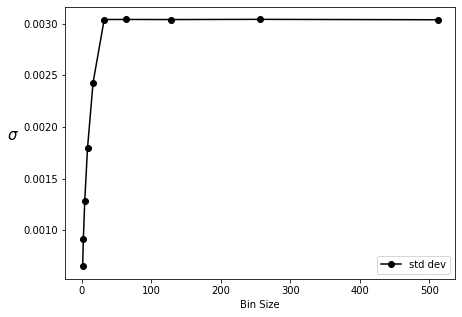

In [15]:
# binning analysis plot
c.pltBins(binSize, stddevs, "std.pdf")

<b>Problem 5</b>: Running code for a $10 \times 10$ lattice. The function called <i>rnd_lattice()</i> creates a random $N \times N$ lattice and is found in the <i>calcs.py</i> file. 

In [16]:
# create a random 10 x 10 lattice
big_lettuce = c.rnd_lattice(10)

In [17]:
# running code for the 10 x 10 lattice at T=10
params_five = {"dim":10, "kb":1.0, "Temperature":10.0,
               "J":1.0, "H":0.0, "n_iter":10000, 
               "matrix":big_lettuce}
E_five, M_five = c.MCMC(params_five)
avg_E_five = np.sum(E_five) / E_five.shape[0]
avg_M_five = np.sum(M_five) / M_five.shape[0]

The Onsager solution at $T=10.0$ compared to my solution.

In [18]:
# comparison to the Onsager solution
T_ten_ons = np.where(T_ons == 10.0)[0][0]
print("The Onsager solution at T=10 is: " + str(E_ons[T_ten_ons]*100)[0:7] + ".")
print("My solution at T=10 is: " + str(avg_E_five)[0:7] + ".")

The Onsager solution at T=10 is: -20.337.
My solution at T=10 is: -20.993.


<b>Problem 7</b>: The magnetization $M$ is calculated for three different values of magnetic field as a function of temperature.

In [19]:
T_array = np.array([0.1, 0.5, 1.0, 1.5, 2.0,
                    2.5, 3.0, 3.5, 5.0, 8.0])

In [36]:
M_list = []
H_list = [0.0, 0.02, 0.1, 0.5]
#H_list = [0.0, 0.0, 0.0]
for k in H_list:
    T, E, M = TvM(k)
    M_list.append(M)

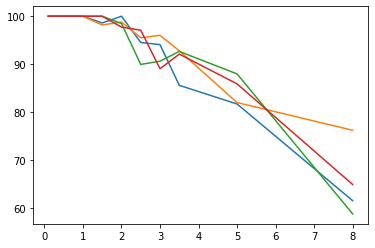

In [37]:
for k in range(4):
    plt.plot(T_array, M_list[k], label="H="+str(H_list[k]))
    plt.xlabel("")
    plt.ylabel("")
plt.show()

In [35]:
def TvM(mag=0.0):
    """
    This function produces the code needed to plot M as a function of T
    for various values of H. The value H is the parameter that is taken
    in here.
    """
    #T_array = np.arange(0.1, 8.0, 0.1)
    T_array = np.array([0.1, 0.5, 1.0, 1.5, 2.0,
                        2.5, 3.0, 3.5, 5.0, 8.0])
    matrix = np.ones([10, 10], float)

    # initialize arrays
    E_list = []
    M_list = []

    # loop over stuff
    for k in range(T_array.shape[0]):
        Tmp = T_array[k]
        params = {"dim":10, "kb":1.0, "Temperature":Tmp,
                  "J":1.0, "H":mag, "n_iter":100, 
                  "matrix":matrix}
        E, M = c.MCMC(params)

        # make calculations
        avg_E = np.sum(E) / E.shape[0]
        avg_M = np.sum(M) / M.shape[0]
        E_list.append(avg_E)
        M_list.append(avg_M)

    return T_array, np.array(E_list), np.array(M_list)